In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ins = pd.read_csv('../input/installments_payments.csv')

In [3]:
ins.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


<font size=4> Just as usualy, first look at the missing rate

In [4]:
ins.isnull().sum() / len(ins)

SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
DAYS_ENTRY_PAYMENT        0.000214
AMT_INSTALMENT            0.000000
AMT_PAYMENT               0.000214
dtype: float64

<font size=5> Plot Distribution

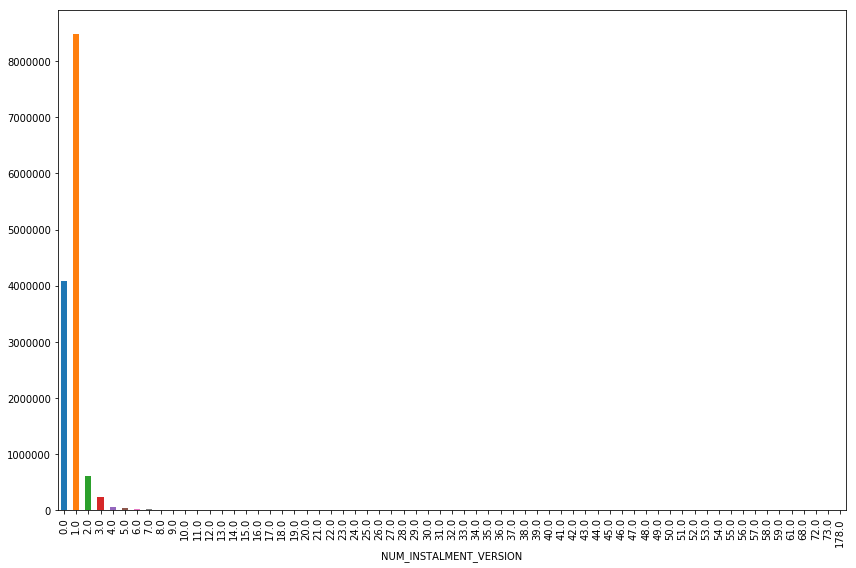

In [5]:
ins.groupby('NUM_INSTALMENT_VERSION').size().plot(kind='bar', figsize=(12, 8))
plt.tight_layout()

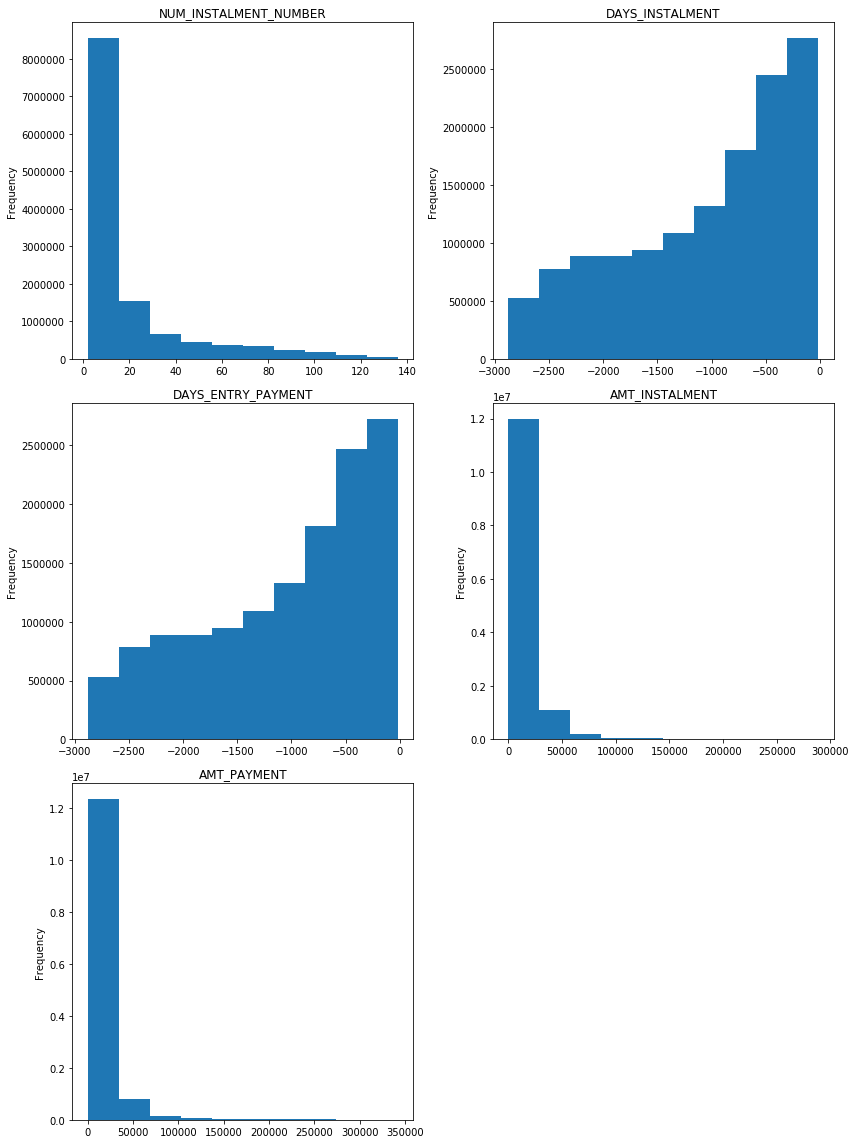

In [6]:
plt.figure(figsize=(12, 16))
for i, col in enumerate(['NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT'], 1):
    plt.subplot(3, 2, i)
    if ins[col].nunique() > 10:
        up_bnd = ins[col].quantile(.995)
        low_bnd = ins[col].quantile(.005)
        ins[(ins[col] > low_bnd) & (ins[col] < up_bnd)][col].plot(kind='hist')
    else:
        ins[col].plot(kind='hist')
    plt.title(col)
plt.tight_layout()

<font size=5> MANUAL FEATURES

In [7]:
ins['AMT_PAYMENT_TO_INSTAL_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['AMT_PAYMENT_SUB_INSTAL'] = ins['AMT_PAYMENT'] - ins['AMT_INSTALMENT']
ins['IS_PAYMENNT_NOT_ENOUGH'] = (ins['AMT_PAYMENT_SUB_INSTAL'] < 0).astype('float')

# Days past due and days before due (no negative values)
ins['DAYS_ENTRY_TO_INSTAL_RATIO'] = ins['DAYS_ENTRY_PAYMENT'] / ins['DAYS_INSTALMENT']
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

<font size=5> Do some aggregation by SK_ID_PREV

In [8]:
agg_by_prev = ins.groupby('SK_ID_PREV')[['DAYS_INSTALMENT']].\
                agg(lambda x: x.max() - x.min()).reset_index().\
                rename(columns={'DAYS_INSTALMENT': 'TIME_SPAN'}).\
                set_index('SK_ID_PREV')
agg_by_prev['INSTALL_TIMES'] = ins.groupby('SK_ID_PREV')['NUM_INSTALMENT_NUMBER'].max()
agg_by_prev['INSTAL_VERSION_N_UNIQUE'] = ins.groupby('SK_ID_PREV')['NUM_INSTALMENT_VERSION'].nunique()
agg_by_prev['INSTAL_VERSION_CHANGE'] = (agg_by_prev['INSTAL_VERSION_N_UNIQUE'] > 1).astype('float')
agg_by_prev['INSTAL_DIVERSITY'] = agg_by_prev['INSTALL_TIMES'] / agg_by_prev['INSTAL_VERSION_N_UNIQUE']

# merge SK_ID_CURR col
agg_by_prev = agg_by_prev.merge(
                    ins[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates('SK_ID_PREV'),
                    on='SK_ID_PREV',
                    how='left')

<font size=5> Do some aggregation by SK_ID_CURR

In [9]:
ins_agg = ins.groupby('SK_ID_CURR')[['SK_ID_PREV']].count().rename(columns={'SK_ID_PREV': 'INSTAL_USR_REC_CNT'})
ins_agg['INSTAL_USR_LOAN_CNT'] = ins.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
ins_agg['INSTAL_REC_CNT_PER_LOAN'] = ins_agg['INSTAL_USR_REC_CNT'] / ins_agg['INSTAL_USR_LOAN_CNT']

In [10]:
prev_aggregation = {
    'TIME_SPAN' : ['min', 'max', 'mean', 'sum'],
    'INSTALL_TIMES': ['min', 'max', 'mean'],
    'INSTAL_VERSION_N_UNIQUE': ['min', 'max', 'mean', 'sum'],
    'INSTAL_VERSION_CHANGE': ['sum', 'mean'],
    'INSTAL_DIVERSITY': ['min', 'max', 'mean']
}

for col, fcn_lst in prev_aggregation.items():
    for fcn in fcn_lst:
        new_col = col + '_' + fcn.upper()
        ins_agg[new_col] = agg_by_prev.groupby('SK_ID_CURR')[col].agg(fcn)

In [11]:
# Features: Perform aggregations
aggregations = {
    # Original Features
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    
    'DAYS_ENTRY_PAYMENT': ['max', 'min'],
    'DAYS_INSTALMENT': ['max', 'min'],

    # Manual Features
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'DAYS_ENTRY_TO_INSTAL_RATIO': ['max', 'mean', 'min'], 
    'AMT_PAYMENT_TO_INSTAL_RATIO': ['min', 'mean', 'var'],
    'AMT_PAYMENT_SUB_INSTAL': ['min', 'mean', 'var'],
    'IS_PAYMENNT_NOT_ENOUGH': ['mean', 'sum'],  
}

ins_agg_auto = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg_auto.columns = pd.Index(
    ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg_auto.columns.tolist()])

recent = ins[ins['DAYS_INSTALMENT'] > -365]
recent_agg = recent.groupby('SK_ID_CURR').agg(aggregations)
recent_agg.columns = pd.Index(
    ['RECENT_INSTAL_' + e[0] + "_" + e[1].upper() for e in recent_agg.columns.tolist()])

ins_agg = ins_agg.merge(ins_agg_auto, on='SK_ID_CURR', how='left')
ins_agg = ins_agg.merge(recent_agg, on='SK_ID_CURR', how='left')

del ins, recent, ins_agg_auto, recent_agg
gc.collect()

24470

In [12]:
for col in ins_agg.columns:
    print(col)

INSTAL_USR_REC_CNT
INSTAL_USR_LOAN_CNT
INSTAL_REC_CNT_PER_LOAN
TIME_SPAN_MIN
TIME_SPAN_MAX
TIME_SPAN_MEAN
TIME_SPAN_SUM
INSTALL_TIMES_MIN
INSTALL_TIMES_MAX
INSTALL_TIMES_MEAN
INSTAL_VERSION_N_UNIQUE_MIN
INSTAL_VERSION_N_UNIQUE_MAX
INSTAL_VERSION_N_UNIQUE_MEAN
INSTAL_VERSION_N_UNIQUE_SUM
INSTAL_VERSION_CHANGE_SUM
INSTAL_VERSION_CHANGE_MEAN
INSTAL_DIVERSITY_MIN
INSTAL_DIVERSITY_MAX
INSTAL_DIVERSITY_MEAN
INSTAL_AMT_INSTALMENT_MAX
INSTAL_AMT_INSTALMENT_MEAN
INSTAL_AMT_INSTALMENT_SUM
INSTAL_AMT_PAYMENT_MIN
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_DAYS_ENTRY_PAYMENT_MAX
INSTAL_DAYS_ENTRY_PAYMENT_MIN
INSTAL_DAYS_INSTALMENT_MAX
INSTAL_DAYS_INSTALMENT_MIN
INSTAL_DPD_MAX
INSTAL_DPD_MEAN
INSTAL_DPD_SUM
INSTAL_DBD_MAX
INSTAL_DBD_MEAN
INSTAL_DBD_SUM
INSTAL_DAYS_ENTRY_TO_INSTAL_RATIO_MAX
INSTAL_DAYS_ENTRY_TO_INSTAL_RATIO_MEAN
INSTAL_DAYS_ENTRY_TO_INSTAL_RATIO_MIN
INSTAL_AMT_PAYMENT_TO_INSTAL_RATIO_MIN
INSTAL_AMT_PAYMENT_TO_INSTAL_RATIO_MEAN
INSTAL_AMT_PAYMENT_TO_I

In [13]:
len(ins_agg.columns)

75

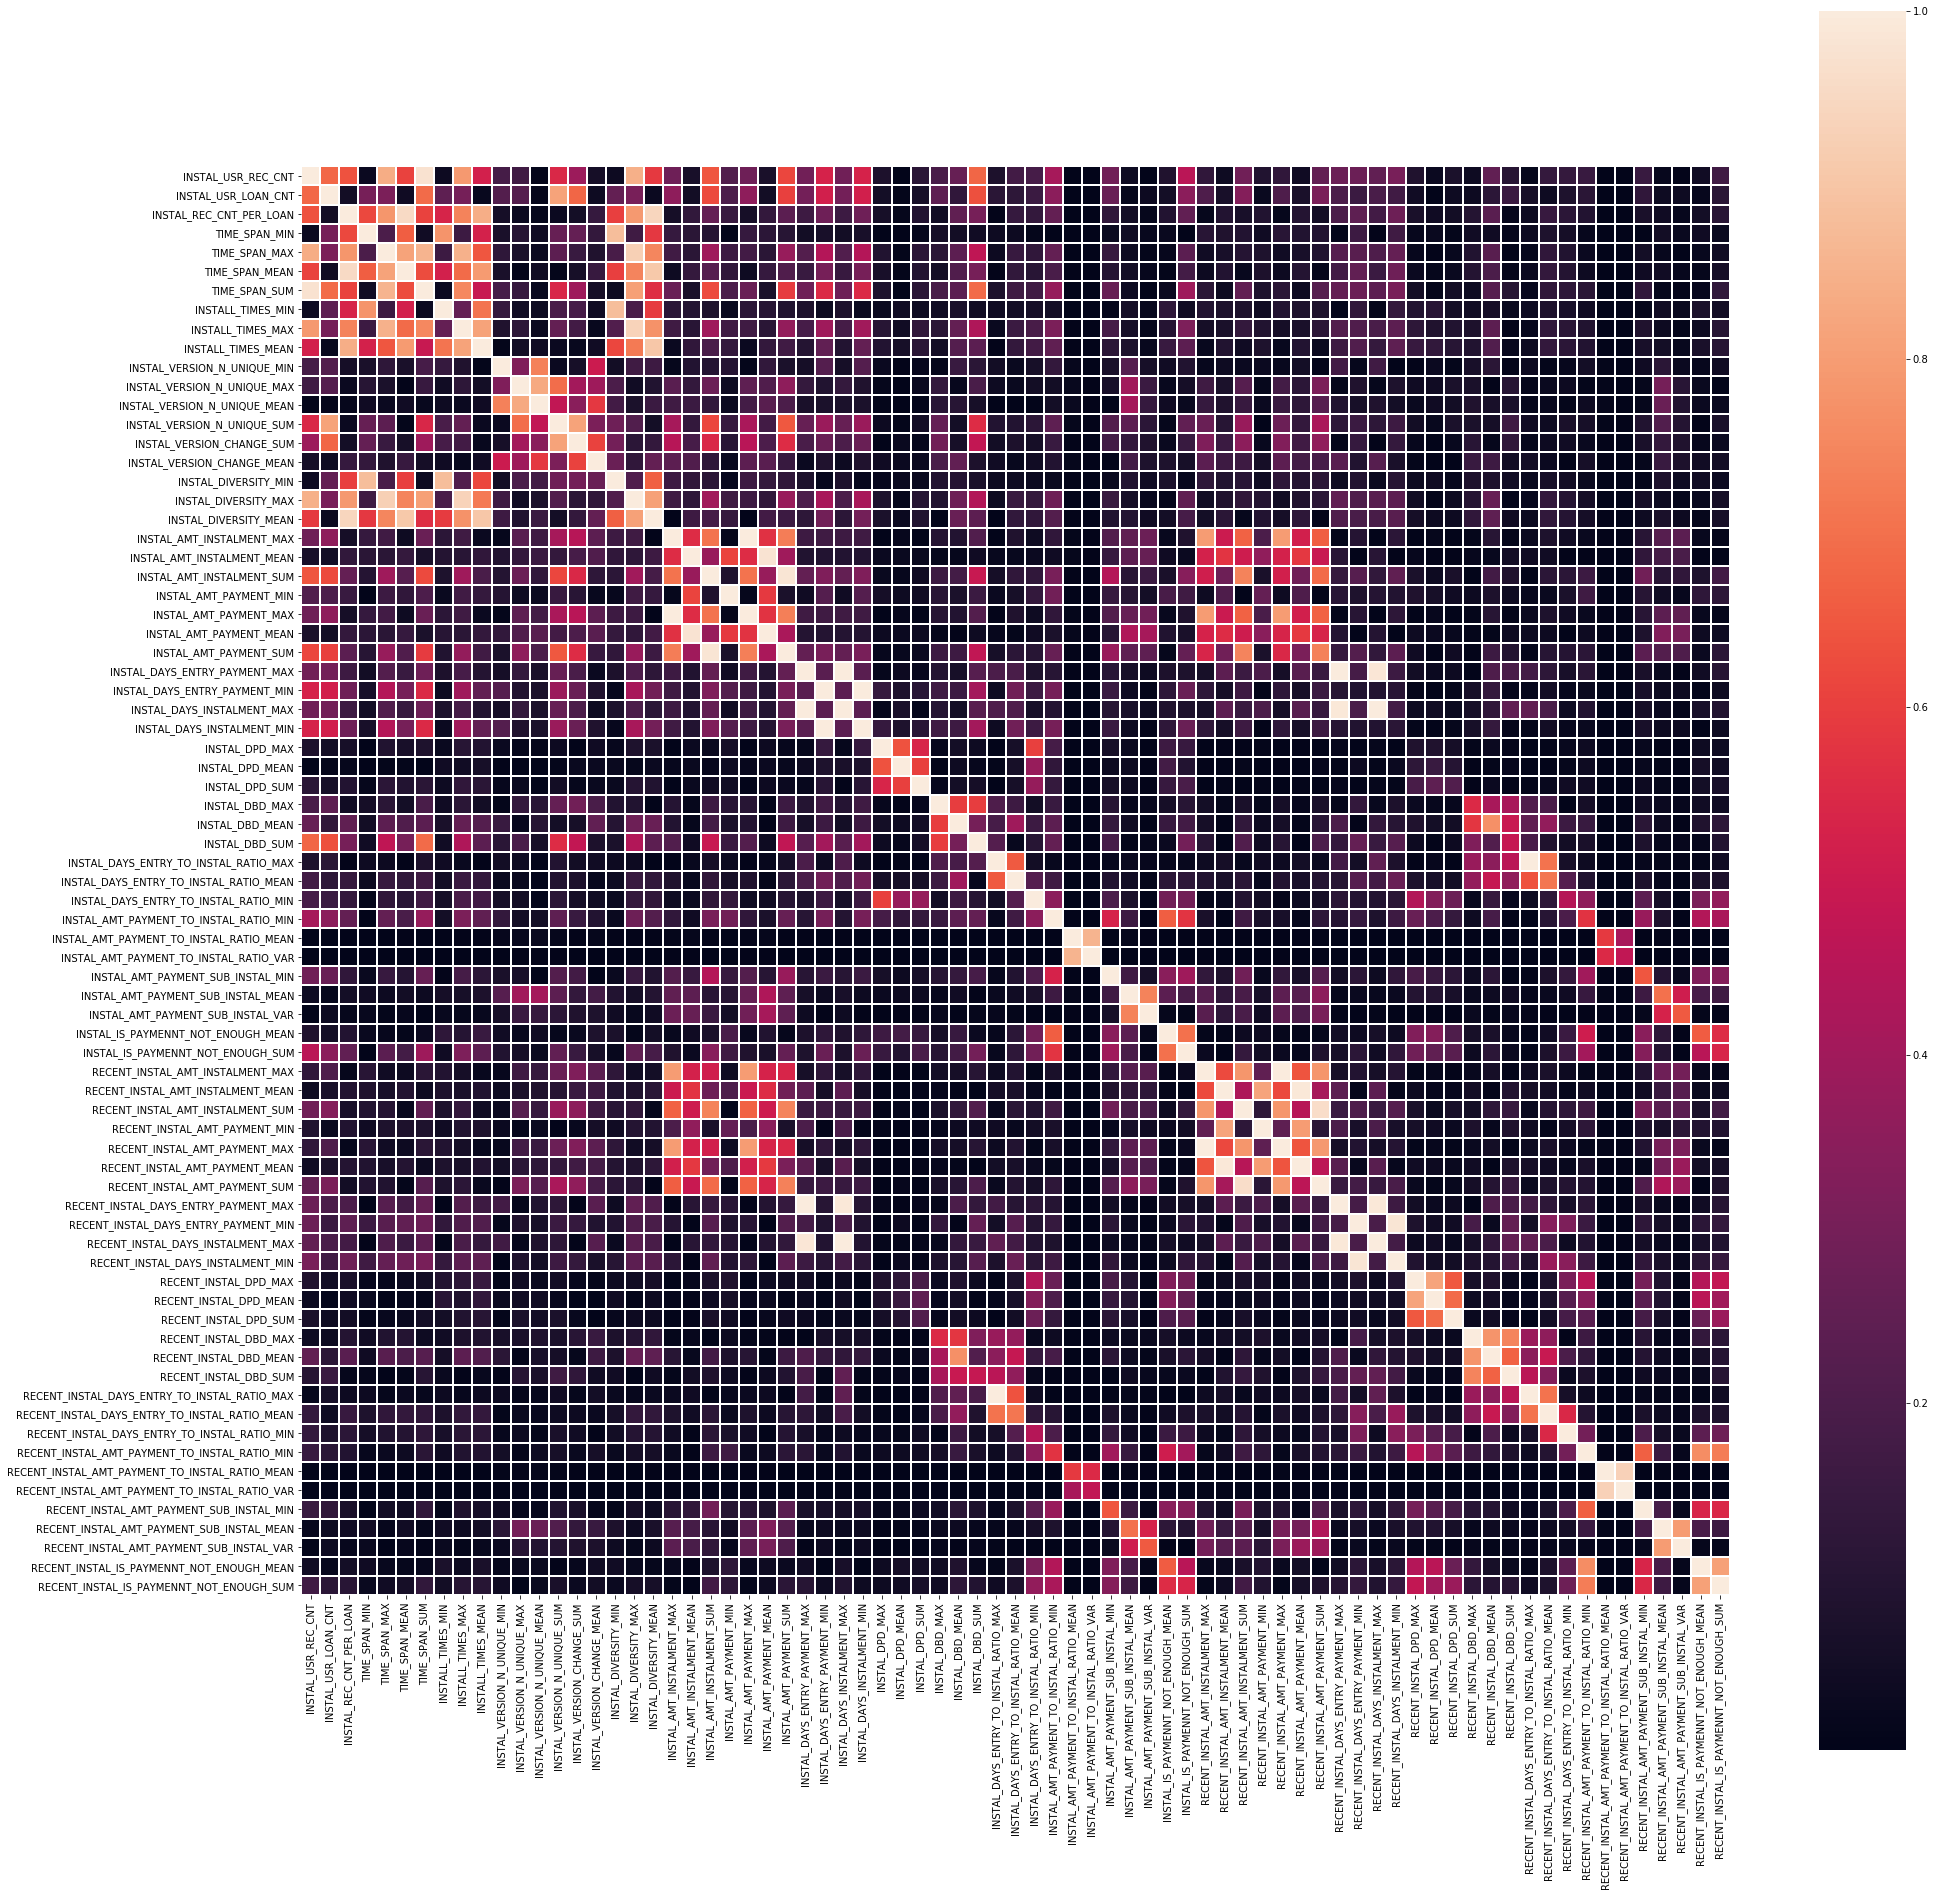

In [14]:
corrMat = ins_agg.corr()
plt.figure(figsize=(32, 32))
sns.heatmap(abs(corrMat), linewidths=1, square=True)

In [15]:
for i in range(1, len(corrMat)):
    for j in range(i):
        if abs(corrMat.iloc[i, j]) >= 0.8:
            feat1, feat2 = corrMat.columns[i], corrMat.columns[j]
            print('%-50s vs. %-50s = %.3f' % (feat1, feat2, corrMat.iloc[i, j]))

TIME_SPAN_MAX                                      vs. INSTAL_USR_REC_CNT                                 = 0.837
TIME_SPAN_MEAN                                     vs. INSTAL_REC_CNT_PER_LOAN                            = 0.957
TIME_SPAN_MEAN                                     vs. TIME_SPAN_MAX                                      = 0.813
TIME_SPAN_SUM                                      vs. INSTAL_USR_REC_CNT                                 = 0.976
TIME_SPAN_SUM                                      vs. TIME_SPAN_MAX                                      = 0.859
INSTALL_TIMES_MAX                                  vs. TIME_SPAN_MAX                                      = 0.850
INSTALL_TIMES_MEAN                                 vs. INSTAL_REC_CNT_PER_LOAN                            = 0.842
INSTALL_TIMES_MEAN                                 vs. INSTALL_TIMES_MAX                                  = 0.813
INSTAL_VERSION_N_UNIQUE_MEAN                       vs. INSTAL_VERSION_N_UNIQUE_MAX      